# Check GPU avaliable

In [111]:
import tensorflow as tf
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

# If using collab

Following cell mounts your google drive into the collab enviroment.

In [ ]:
%cd /content/drive/MyDrive/datasets/
!ls

Once uploaded, you can unzip the files using the following cells.

In [ ]:
# For test set 
!unzip faces_dataset_test.zip

In [ ]:
# For train set (it takes around 15 mins but only needs to be executed once)
!unzip faces_dataset_train.zip

You can use the following cells to check that everything has been decompresed correctly. I just check that the *metadata.json* file exists in the decompressed folders.

In [ ]:
%cd /content/drive/MyDrive/datasets/faces_dataset_train/
%ls | grep metadata
%cd /content/drive/MyDrive/datasets/faces_dataset_test/
%ls | grep metadata

# Preparation

## Execute this cell if you are using collab with the corresponding paths:

In [ ]:
# Dataset path
from os import listdir
import os.path

PATH = '/content/drive/MyDrive/datasets/faces_dataset_train/'
PATH_TEST = '/content/drive/MyDrive/datasets/faces_dataset_test/'

assert os.path.exists(PATH), 'Verify the above commands'
assert os.path.exists(PATH_TEST), 'Verify the above commands'

## Or if you are using a local enviroment, use your local paths:

In [113]:
# Dataset path
from os import listdir
import os.path

PATH = 'faces_dataset_train/'
PATH_TEST = 'faces_dataset_test/'

assert os.path.exists(PATH), 'Verify the above commands'
assert os.path.exists(PATH_TEST), 'Verify the above commands'

# Preprocessing

### Metadata access

In [20]:
import json

with open(PATH + 'metadata.json') as fIn:
    metadata = json.loads(fIn.read())
with open(PATH_TEST + 'metadata.json') as fIn:
    metadata_test = json.loads(fIn.read())

metadata_example_key = next(iter(metadata.keys()))
metadata_example_value = metadata[metadata_example_key]

print(metadata_example_key, end=' ----> ')
print(metadata_example_value)

i07/nm0322407_rm852269056_1955-3-29_2005.jpg ----> {'age': 50, 'gender': 'M'}


### Image reading

In [4]:
import os    
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

In [21]:
def decode_img(img):
    '''Transforms a string that represents the path of an image into a matrix
    (img_height, img_width, 3) of uint8 representing the pixel values
    '''
    # Convert the compressed string to a 3D uint8 tensor
    img = tf.io.decode_jpeg(img, channels=3)
    # Resize the image to the desired size.
    return tf.cast(tf.image.resize(img, [img_height, img_width]),tf.uint8)

def process_path(file_path):
    '''Transforms strings of the form 'path|age|gender' to tuples (image, label)
    '''
    parts = tf.strings.split(file_path, '|')
    age = parts[1]
    age = tf.strings.to_number(age, out_type=tf.dtypes.int32)
    gender = parts[2]
    # Load the raw data from the file as a string
    img = tf.io.read_file(parts[0])
    img = decode_img(img)
    return img, age


def format_metadata(m, path):
    '''Transforms the metadata dictionary m into a list of strings of the form 'path to the image|age|gender'.
    '''
    return list(map(lambda x: '{0}{1}|{2}|{3}'.format(path,x,m[x]['age'],m[x]['gender']),m.keys()))

<TakeDataset shapes: (), types: tf.string>
Image shape:  (128, 128, 3)
Label:  44


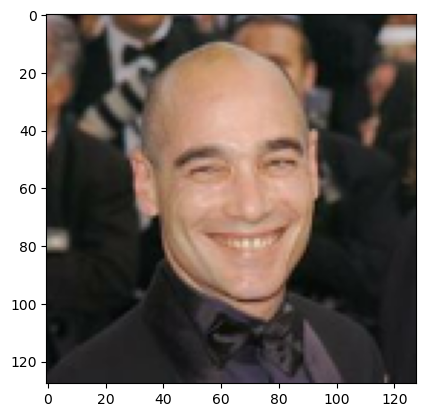

Image shape:  (128, 128, 3)
Label:  44


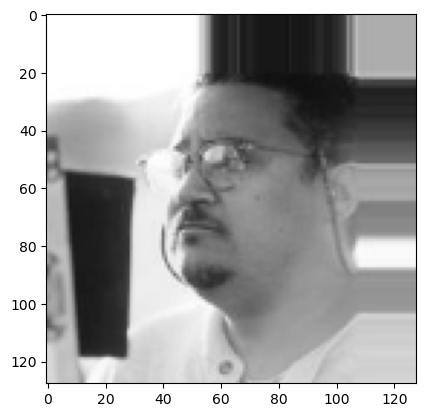

Image shape:  (128, 128, 3)
Label:  43


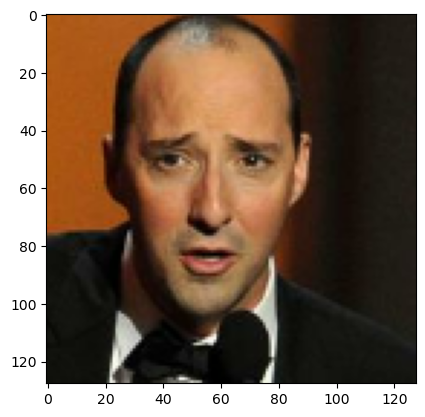

Image shape:  (128, 128, 3)
Label:  41


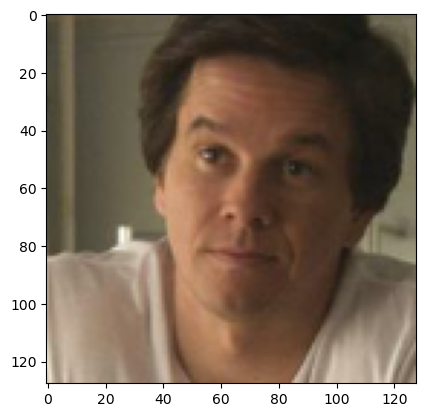

Image shape:  (128, 128, 3)
Label:  70


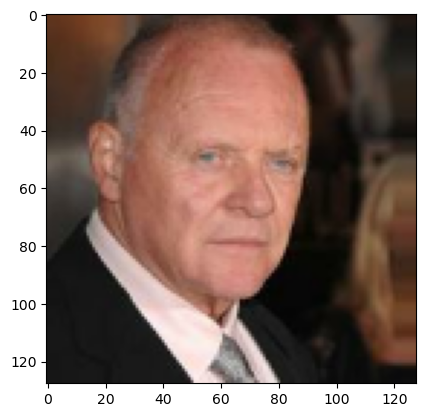

In [71]:
import tensorflow as tf
from matplotlib import pyplot

# Size at which images will be processed
img_height = 128
img_width = 128

# We build a dataset of text strings from the metadata
train_metadata = format_metadata(metadata, PATH)
train_ds = tf.data.Dataset.from_tensor_slices(train_metadata)
print(train_ds.take(1))

# Mapping to an image dataset with tags
train_ds = train_ds.shuffle(len(train_ds)).map(process_path)

# Same process for test
test_ds = tf.data.Dataset.from_tensor_slices(format_metadata(metadata_test, PATH_TEST))
test_ds = test_ds.map(process_path)

# Checking
for image, label in train_ds.take(5):
    print("Image shape: ", image.numpy().shape)
    print("Label: ", label.numpy())
    pyplot.imshow(image.numpy())
    pyplot.show()

In [ ]:
ds_train_transform = train_ds
ds_test_transform = test_ds
print(train_metadata[0])

In [73]:
# OPTIONAL: rescaling input to [-1, 1]
ds_train_transform = ds_train_transform.map(lambda image, label: (tf.cast(image, tf.float32)/127.5 - 1., label))
ds_test_transform = ds_test_transform.map(lambda image, label: (tf.cast(image, tf.float32)/127.5 - 1., label))

In [74]:
# OPTIONAL: rescaled output to [0, 1]
import numpy as np
labels = [int(x.split('|')[1]) for x in train_metadata]
max_age = tf.convert_to_tensor(np.max(labels), tf.float32)
ds_train_transform = ds_train_transform.map(lambda image, label: (image, tf.cast(label, tf.float32)/max_age))
ds_test_transform = ds_test_transform.map(lambda image, label: (image, tf.cast(label, tf.float32)/max_age))

In [75]:
# OPTIONAL: sample age weights
import numpy as np
step = 10
labels = [int(x.split('|')[1]) for x in train_metadata]
freqs, bins = np.histogram(labels, bins=list(range(0,100,step)) + [200])
i_freqs = 1. / freqs
sample_weights = tf.convert_to_tensor(len(i_freqs) * i_freqs / i_freqs.sum())
print(sample_weights)
ds_train_transform = ds_train_transform.map(lambda image, label: (image, label, sample_weights[tf.minimum(tf.cast(label, tf.int32) // step, len(i_freqs) - 1)]))
ds_test_transform = ds_test_transform.map(lambda image, label: (image, label, sample_weights[tf.minimum(tf.cast(label, tf.int32) // step, len(i_freqs) - 1)]))

tf.Tensor(
[1.76150383 0.08628557 0.01546083 0.01225852 0.01755069 0.03502511
 0.06879879 0.16056922 0.52553153 7.31701591], shape=(10,), dtype=float64)


In [76]:
batch_size = 128
ds_train_batch = ds_train_transform.batch(batch_size)
ds_test_batch = ds_test_transform.batch(batch_size)

## First model from scratch

First I try the same base model as in the gender prediction notebook, with blocks of Conv2D and MaxPooling layers, increasing the number of filters on each block while reducing the dimensions of the features maps. 

Some little changes to addapt the architecture for this regression task:
- Added a first layer with 5x5 kernel size followed by a 3x3 one without maxpooling
- Added l2 regularized to intermediate convolutional layers
- Activation linear instead of sigmoid (both are suitable for regression tasks, but I choose linear for this approach)
- MAE metric instead of accuracy
- Mean absolute error as loss function

I tried as first with 20 epochs with 64x64 images.

In [56]:
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import layers, regularizers

model = keras.Sequential([
    layers.Conv2D(32, (5, 5), activation='relu', input_shape=(64, 64, 3)),
    layers.Conv2D(64, (3, 3), activation='relu',kernel_regularizer=regularizers.l2(0.001)),
    layers.MaxPooling2D((2, 2)),
    
    layers.Conv2D(128, (3, 3),activation='relu',kernel_regularizer=regularizers.l2(0.001)),
    layers.MaxPooling2D((2, 2)),
    
    layers.Conv2D(256, (3, 3), activation='relu'),
    layers.Flatten(),


    layers.Dense(1, activation='linear')
])

In [60]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_28 (Conv2D)          (None, 60, 60, 32)        2432      
                                                                 
 conv2d_29 (Conv2D)          (None, 58, 58, 64)        18496     
                                                                 
 max_pooling2d_18 (MaxPoolin  (None, 29, 29, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_30 (Conv2D)          (None, 27, 27, 128)       73856     
                                                                 
 max_pooling2d_19 (MaxPoolin  (None, 13, 13, 128)      0         
 g2D)                                                            
                                                                 
 conv2d_31 (Conv2D)          (None, 11, 11, 256)      

In [58]:
model.compile(loss='mse', optimizer='adam', metrics=['mae'])

history = model.fit(ds_train_batch,
                    epochs=20,
                    validation_data=ds_test_batch)

Epoch 1/20
992/992 [==============================] - 10s 10ms/step - loss: 0.0284 - mae: 0.0973 - val_loss: 0.1011 - val_mae: 0.1953
Epoch 2/20
992/992 [==============================] - 9s 9ms/step - loss: 0.0255 - mae: 0.0918 - val_loss: 0.0893 - val_mae: 0.1822
Epoch 3/20
992/992 [==============================] - 10s 10ms/step - loss: 0.0241 - mae: 0.0886 - val_loss: 0.0914 - val_mae: 0.1838
Epoch 4/20
992/992 [==============================] - 10s 10ms/step - loss: 0.0228 - mae: 0.0855 - val_loss: 0.0798 - val_mae: 0.1704
Epoch 5/20
992/992 [==============================] - 10s 10ms/step - loss: 0.0217 - mae: 0.0831 - val_loss: 0.0785 - val_mae: 0.1690
Epoch 6/20
992/992 [==============================] - 10s 10ms/step - loss: 0.0210 - mae: 0.0815 - val_loss: 0.0710 - val_mae: 0.1587
Epoch 7/20
992/992 [==============================] - 10s 10ms/step - loss: 0.0205 - mae: 0.0805 - val_loss: 0.0751 - val_mae: 0.1638
Epoch 8/20
992/992 [==============================] - 10s 10ms/s

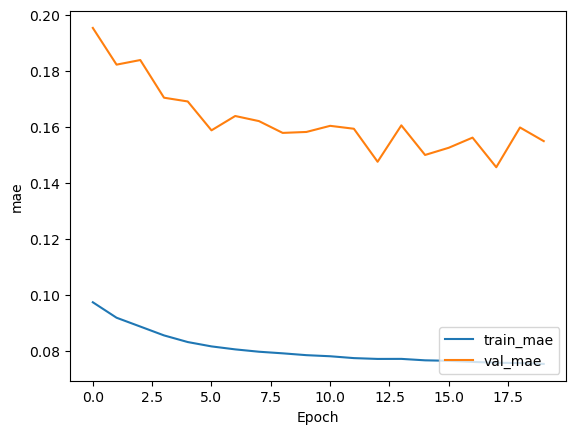

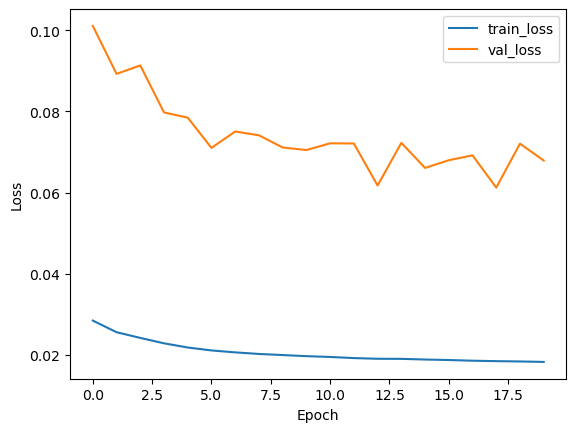

In [59]:
# Plot the results
import matplotlib.pyplot as plt

plt.plot(history.history['mae'], label='train_mae')
plt.plot(history.history['val_mae'], label='val_mae')
plt.xlabel('Epoch')
plt.ylabel('mae')
plt.legend(loc='lower right')
plt.show()

plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.show()

It can be seen that this very basic architecture performs quite bad for this task, and the overfit is even more pronunced than on the first attempts predicting gender. Trying another hyperparameters (like other optimizers or even sigmoid as activation function instead of linear) does not improve the model performance. 


To take a different approach, I used the previously trained model for gender prediction and applyed transfer learning. Specifically, I use a fine tunning approach freezing some trained layers in the previous model, and training only some of them, also adding new layers. 

Also, the same preprocessing was done as in the previous approach, taking 20% of the training set as validation to have more validation data. Appart from this, the rest of the code is exactly the same as above, rescaling input to [-1,1], output to [0,1] and stratifying age weights. 

In [ ]:
import json
def decode_img(img):
    '''Transforms a string that represents the path of an image into a matrix
    (img_height, img_width, 3) of uint8 representing the pixel values
    '''
    # Convert the compressed string to a 3D uint8 tensor
    img = tf.io.decode_jpeg(img, channels=3)
    # Resize the image to the desired size.
    return tf.cast(tf.image.resize(img, [img_height, img_width]),tf.uint8)

def process_path(file_path):
    '''Transforms strings of the form 'path|age|gender' to tuples (image, label)
    '''
    parts = tf.strings.split(file_path, '|')
    age = parts[1]
    age = tf.strings.to_number(age, out_type=tf.dtypes.int32)
    gender = parts[2]
    # Load the raw data from the file as a string
    img = tf.io.read_file(parts[0])
    img = decode_img(img)
    return img, age

def format_metadata(m, path):
    '''Transforms the metadata dictionary m into a list of strings of the form 'path to the image|age|gender'.
    '''
    return list(map(lambda x: '{0}{1}|{2}|{3}'.format(path,x,m[x]['age'],m[x]['gender']),m.keys()))


with open(PATH + 'metadata.json') as fIn:
    metadata = json.loads(fIn.read())
with open(PATH_TEST + 'metadata.json') as fIn:
    metadata_test = json.loads(fIn.read())

metadata_example_key = next(iter(metadata.keys()))
metadata_example_value = metadata[metadata_example_key]

print(metadata_example_key, end=' ----> ')
print(metadata_example_value)

# Size at which images will be processed
img_height = 128
img_width = 128


import tensorflow as tf
from matplotlib import pyplot

# We build a dataset of text strings from the metadata
train_metadata = format_metadata(metadata, PATH)
train_ds = tf.data.Dataset.from_tensor_slices(train_metadata)

# Split in training and validation from training set
validation_percentage = 20

train_size = int((100 - validation_percentage) / 100.0 * len(train_ds))
validation_size = len(train_ds) - train_size

train_ds = train_ds.shuffle(len(train_ds)) # shuffle data
validation_ds = train_ds.take(validation_size).map(process_path) # take images of 20% of the dataset
train_ds = train_ds.skip(validation_size).map(process_path) # take images unless the other 20%

ds_train_transform = train_ds
ds_test_transform = validation_ds
print(train_metadata[0])

# OPTIONAL: rescaling input to [-1, 1]
ds_train_transform = ds_train_transform.map(lambda image, label: (tf.cast(image, tf.float32)/127.5 - 1., label))
ds_test_transform = ds_test_transform.map(lambda image, label: (tf.cast(image, tf.float32)/127.5 - 1., label))

# OPTIONAL: rescaled output to [0, 1]
import numpy as np
labels = [int(x.split('|')[1]) for x in train_metadata]
max_age = tf.convert_to_tensor(np.max(labels), tf.float32)
ds_train_transform = ds_train_transform.map(lambda image, label: (image, tf.cast(label, tf.float32)/max_age))
ds_test_transform = ds_test_transform.map(lambda image, label: (image, tf.cast(label, tf.float32)/max_age))

# OPTIONAL: sample age weights
import numpy as np
step = 10
labels = [int(x.split('|')[1]) for x in train_metadata]
freqs, bins = np.histogram(labels, bins=list(range(0,100,step)) + [200])
i_freqs = 1. / freqs
sample_weights = tf.convert_to_tensor(len(i_freqs) * i_freqs / i_freqs.sum())
print(sample_weights)
ds_train_transform = ds_train_transform.map(lambda image, label: (image, label, sample_weights[tf.minimum(tf.cast(label, tf.int32) // step, len(i_freqs) - 1)]))
ds_test_transform = ds_test_transform.map(lambda image, label: (image, label, sample_weights[tf.minimum(tf.cast(label, tf.int32) // step, len(i_freqs) - 1)]))

In [135]:
print('Test set size: ' + str(len(ds_test_transform)))
print('Train set size: ' + str(len(ds_train_transform)))

batch_size = 128
ds_train_batch = ds_train_transform.batch(batch_size)
ds_test_batch = ds_test_transform.batch(batch_size)

Test set size: 25373
Train set size: 101492


First we load the saved model (the one with better results in the other notebook)

In [136]:
import keras
from keras import layers
from keras.models import load_model

model_path = 'models/first_fixed.h5'
model = load_model(model_path)

The architecture is described below

In [84]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 126, 126, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 63, 63, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 61, 61, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 30, 30, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 28, 28, 128)       73856 

Now the last three layers are frozen and new ones were added, specifically, a dense layer that is connected with the last frozen layer, a dropout layer of 0.5 and a last dense layer with only 1 neuron to perform the regression task with a linear activation.

In [139]:
for layer in model.layers[:-3]:
    layer.trainable = False
    
x = model.layers[-2].output
x = layers.Dense(128, activation='relu')(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation='linear')(x)

new_model = keras.Model(inputs=model.inputs, outputs=outputs)

Training the model:

In [125]:
new_model.compile(loss='mse', optimizer='adam', metrics=['mae'])
history = new_model.fit(ds_train_batch,
                    epochs=20,
                    validation_data=ds_test_batch)

Epoch 1/20
793/793 [==============================] - 8s 10ms/step - loss: 0.1308 - mae: 0.1986 - val_loss: 0.0355 - val_mae: 0.1090
Epoch 2/20
793/793 [==============================] - 8s 10ms/step - loss: 0.0346 - mae: 0.1101 - val_loss: 0.0340 - val_mae: 0.1101
Epoch 3/20
793/793 [==============================] - 8s 10ms/step - loss: 0.0346 - mae: 0.1107 - val_loss: 0.0345 - val_mae: 0.1106
Epoch 4/20
793/793 [==============================] - 8s 10ms/step - loss: 0.0342 - mae: 0.1097 - val_loss: 0.0317 - val_mae: 0.1054
Epoch 5/20
793/793 [==============================] - 8s 10ms/step - loss: 0.0324 - mae: 0.1064 - val_loss: 0.0300 - val_mae: 0.1026
Epoch 6/20
793/793 [==============================] - 8s 10ms/step - loss: 0.0315 - mae: 0.1045 - val_loss: 0.0289 - val_mae: 0.0994
Epoch 7/20
793/793 [==============================] - 8s 10ms/step - loss: 0.0309 - mae: 0.1031 - val_loss: 0.0279 - val_mae: 0.0975
Epoch 8/20
793/793 [==============================] - 8s 10ms/step - 

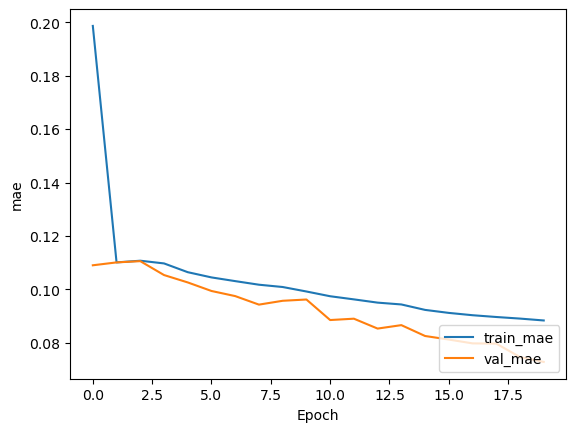

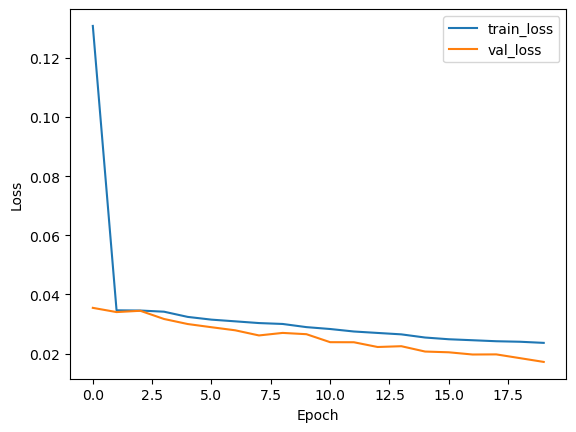

In [126]:
# Plot the results
import matplotlib.pyplot as plt

plt.plot(history.history['mae'], label='train_mae')
plt.plot(history.history['val_mae'], label='val_mae')
plt.xlabel('Epoch')
plt.ylabel('mae')
plt.legend(loc='lower right')
plt.show()

plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.show()

In [127]:
model.save("models/age1.h5")

With this modifications, the results are better. Lets try with more epochs as it seems that the model can improve a little more its results.

In [140]:
new_model.compile(loss='mse', optimizer='adam', metrics=['mae'])
early_stopping = EarlyStopping(monitor='val_mae', patience=10, restore_best_weights=True)

history = new_model.fit(ds_train_batch,
                    epochs=50,
                    validation_data=ds_test_batch,
                       callbacks=[early_stopping])

Epoch 1/50
793/793 [==============================] - 8s 10ms/step - loss: 0.0612 - mae: 0.1387 - val_loss: 0.0223 - val_mae: 0.0863
Epoch 2/50
793/793 [==============================] - 8s 10ms/step - loss: 0.0248 - mae: 0.0915 - val_loss: 0.0185 - val_mae: 0.0805
Epoch 3/50
793/793 [==============================] - 8s 10ms/step - loss: 0.0217 - mae: 0.0861 - val_loss: 0.0176 - val_mae: 0.0779
Epoch 4/50
793/793 [==============================] - 8s 10ms/step - loss: 0.0200 - mae: 0.0827 - val_loss: 0.0149 - val_mae: 0.0718
Epoch 5/50
793/793 [==============================] - 8s 10ms/step - loss: 0.0190 - mae: 0.0804 - val_loss: 0.0141 - val_mae: 0.0699
Epoch 6/50
793/793 [==============================] - 8s 10ms/step - loss: 0.0182 - mae: 0.0785 - val_loss: 0.0130 - val_mae: 0.0671
Epoch 7/50
793/793 [==============================] - 8s 10ms/step - loss: 0.0175 - mae: 0.0769 - val_loss: 0.0128 - val_mae: 0.0666
Epoch 8/50
793/793 [==============================] - 8s 10ms/step - 

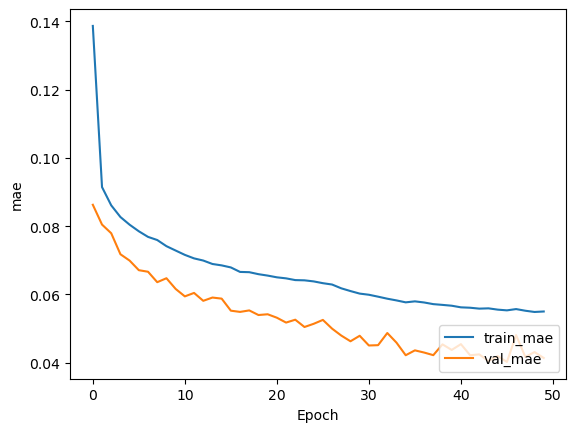

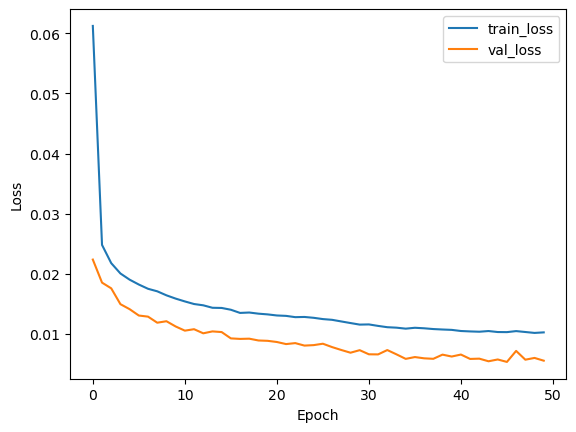

In [141]:
# Plot the results
import matplotlib.pyplot as plt

plt.plot(history.history['mae'], label='train_mae')
plt.plot(history.history['val_mae'], label='val_mae')
plt.xlabel('Epoch')
plt.ylabel('mae')
plt.legend(loc='lower right')
plt.show()

plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.show()

In [142]:
model.save("models/age2.h5")

# Conclussions

Being a regression task rather than a classification task, the approach is a bit different in this case. The last layer still consists of a neuron, but this time using a different activation function. Also, instead of BinaryCrossentropy as the error function, in this case we use the mean square error. Trying different architectures, we can see that the results are similar to the first release, obtaining results below the minimum expected with simple architectures. Therefore, we have used fine-tunning of the previous model, applying a slightly different preprocessing to the images but keeping the idea of dividing into another training subset and a validation subset in order to obtain more data to validate with during training. With this idea and training over 50 epochs, the training stops at epoch 30 due to the EarlyStopping callback with a patience of 5 epochs, since no improvement in val_mae has been detected, and restoring the weights of the best result, in this case obtaining an MAE of 0.0414 (~4 years).
